In [62]:
from PIL import Image ## pip install pillow
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
import csv, gzip, shutil, re
import subprocess
from pathlib import Path

tmp_dir = Path('tmp-dir')
def clean_tmp_dir():
    tmp_dir.mkdir(exist_ok=True)
    for p in tmp_dir.iterdir(): p.unlink()

def get_extent(arr): return [min(arr), max(arr)]


In [2]:
## vid2csv

scale_down_factor = 4

clean_tmp_dir()
subprocess.run(f'ffmpeg -i waterfall.apng.png -vf scale=iw/{scale_down_factor}:ih/{scale_down_factor} {tmp_dir}/%d.png'.split())
if not (tmp_dir/'1.png').exists(): raise Exception("ffmpeg failes!")

img_paths = sorted(tmp_dir.iterdir(), key=lambda p:int(p.name.split('.')[0]))
vid_size_str = 'x'.join(map(str,Image.open(img_paths[0]).size))
    
def get_pixelvec_for_path(path): return np.array(Image.open(path).convert('L').getdata())
pixelvecs = [list(get_pixelvec_for_path(p)) for p in img_paths]

csv_path = f'waterfall-{vid_size_str}.csv.gz'
with gzip.open(csv_path, 'wt', compresslevel=5) as f:
    writer = csv.writer(f)
    writer.writerows(pixelvecs)

In [47]:
## Note: I had to remove the colnames and rownames from `waterfall_471x265_rank5.csv.gz`.
## I used this command:
## zcat waterfall_265x471_rank5.csv.gz | sed 's_^"[0-9]*",__' | sed -E 's_\.[0-9]+__g' | tail -n +2 | gzip -3 > waterfall-471x265-rank5.csv.gz


In [52]:
## csv2vid

# Parse size
csv_path = max(Path().glob('waterfall*.csv.gz'), key=lambda p:p.stat().st_mtime)  # newest!
vid_width, vid_height = [int(d) for d in re.match(r'.*[_-]([0-9]+)x([0-9]+)[-_\.]', str(csv_path)).groups()]
print(f'{vid_width}x{vid_height}')

# Get first row, reshape as np matrix, turn into image.
pixelmat = np.genfromtxt(csv_path,delimiter=',',dtype=np.int16)  # Does it need to be float?  Should I round it?
print(f'range =', pixelmat.min(), pixelmat.max())
pixelmat = pixelmat.clip(min=0,max=255)
print(f'{pixelmat.shape=}')

# Compute a new even width & height, because mp4
width = vid_width // 2 * 2
height = vid_height // 2 * 2

# Save frames into tmp_dir/#.png
clean_tmp_dir()
for frame in range(pixelmat.shape[0]):
    im = Image.fromarray(pixelmat[frame,].reshape((vid_height,vid_width)).astype(np.uint8))
    im = im.crop((0,0,width,height))
    if frame == 0: print(f'{width}x{height}')
    im.save(tmp_dir / f'{frame}.png')

# Join the frames into an mp4
subprocess.run(f'ffmpeg -y -hide_banner -r 30 -i {tmp_dir}/%d.png -vf fps=30 -vcodec libx264 -pix_fmt yuv420p {csv_path}.mp4'.split())


235x132
range = 0 245
pixelmat.shape=(380, 31020)
234x132


CompletedProcess(args=['ffmpeg', '-y', '-r', '30', '-i', 'tmp-dir/%d.png', '-vf', 'fps=30', '-vcodec', 'libx264', '-pix_fmt', 'yuv420p', 'waterfall-235x132.csv.gz.mp4'], returncode=0)

In [3]:
pixelvecs = np.matrix(pixelvecs)
print(f'{pixelvecs.shape=}')
U,S,Vt = svd(pixelvecs, full_matrices=False)
print(f'{U.shape=} {S.shape=} {Vt.shape=}')

pixelvecs.shape=(380, 31020)


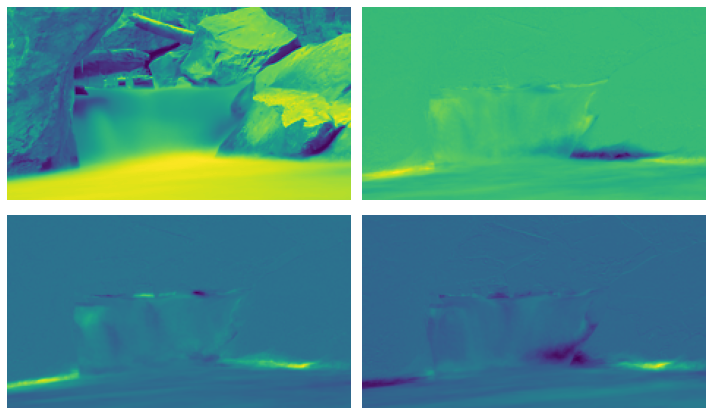

In [106]:
fig, axes = plt.subplots(2,2, figsize=(10,6))

for i in range(4):
    x = np.array(list(Vt[i,:].flat)).reshape((132,235))
    plt.sca(axes.flatten()[i])
    plt.imshow(-x, cmap=plt.get_cmap('viridis'))
    plt.axis('off')
plt.tight_layout()

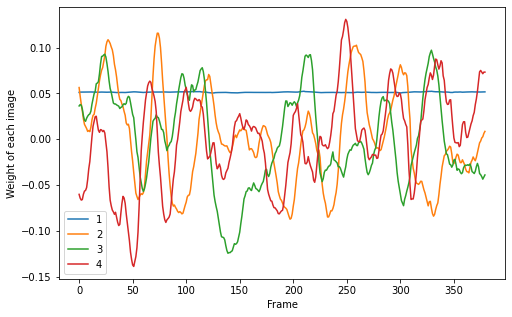

In [113]:
fig, ax = plt.subplots(1, figsize=(8,5))
for i in range(4):
    x = -np.array(list(U[:,i].flat))
    plt.plot(x, label=i+1)
plt.xlabel('Frame'); plt.ylabel('Weight of each image')
plt.legend()
plt.show()